In [1]:
import torch
import torchvision
import os

try:
  from google.colab import drive
  drive.mount('/content/drive')

  os.chdir('/content/drive/MyDrive/GitHub/kornia')
except Exception:   # Not run on Google Colab
  import getpass
  if getpass.getuser() == 'vscode':       # Running in container
    os.chdir('/workspaces/kornia/')
  else:                                   # Running in virtual environment
    os.chdir(os.path.join(os.path.expanduser('~'), 'Documents/Git/kornia/'))

print(os.getcwd())
import sys
sys.path.append(os.getcwd())
cwd_path = os.getcwd()

from kornia.geometry.nerf.camera_utils import CameraParser, parse_colmap_output, cameras_for_ids
from kornia.geometry.nerf.nerf_solver import NerfSolver
from torchvision.io import read_image
import matplotlib.pyplot as plt
import glob

/workspaces/kornia


## Load scene images and plot one of them

torch.Size([3, 756, 1008])
10


torch.Size([189, 252, 3])

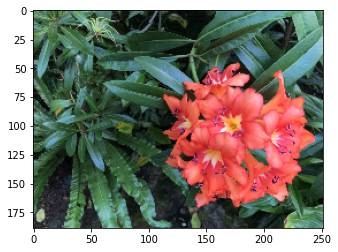

In [2]:
img_paths = sorted(glob.glob('kornia/geometry/nerf/kornia_nerf_data/flower_4/images/*.png'))
img0 = read_image(img_paths[0])
print(img0.shape)

downscale = 4.  # Scaling facor to downsize images for faster computation
height = int(img0.shape[1] / downscale)
width = int(img0.shape[2] / downscale)
transform = torchvision.transforms.Resize((height, width))
imgs: torch.tensor = []
camera_ids = []
num_cams_to_load = 10
for i, img_path in enumerate(img_paths):
    if num_cams_to_load != -1 and i == num_cams_to_load:
        break
    img = read_image(img_path)
    img = transform(img)  # Uncomment to apply downsizing
    imgs.append(img)
    camera_ids.append(i)

print(len(imgs))
img_plt = torch.permute(imgs[0], (1, 2, 0))
plt.imshow(img_plt)
img_plt.shape

## Parse cameras from estimated pos xml

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(device)

# camera_parser = CameraParser('./test/geometry/nerf/cameras.xml', device=device)
# cameras = camera_parser.create_cameras()

# cameras = create_cameras_at_origin(cameras) # Put all cameras at origin, facing positive z-axis
# cameras = initialize_cameras_at_origin(cameras) # Initialize all cameras at origin, focals equals image size
# cameras = initialize_camera_symmetric_intrinsics(cameras)   # Initialize camera intrinsics to symmetric

# cameras.extrinsics[..., :3, :3] *= -1.

cameras = parse_colmap_output(cameras_path='./test/geometry/nerf/cameras.txt', 
                              images_path='./test/geometry/nerf/images.txt', device=device)

# To use same subset of cameras as input images
cameras = cameras_for_ids(cameras, camera_ids)

# Downscaling cameras
cameras = cameras.scale(1. / downscale)

print(cameras.batch_size)
print(f'Intrinsics: \n{cameras.intrinsics[0]}; \nExtrinsics: \n{cameras.extrinsics[0]}')

cpu
10
Intrinsics: 
tensor([[218.9898,   0.0000, 125.1791,   0.0000],
        [  0.0000, 218.9898, 102.3121,   0.0000],
        [  0.0000,   0.0000,   1.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   1.0000]]); 
Extrinsics: 
tensor([[ 0.9977,  0.0050, -0.0674, -1.7739],
        [ 0.0060, -0.9999,  0.0156,  0.1901],
        [-0.0673, -0.0160, -0.9976,  0.0656],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


## Run training on image scene

In [4]:
# nerf_obj = NerfSolver(device=device)
# num_img_rays = 256
# batch_size = 256
# nerf_obj.init_training(cameras=cameras, min_depth=1., max_depth=2., ndc=True, imgs=imgs, num_img_rays=num_img_rays, 
#                        batch_size=batch_size, num_ray_points=128)

In [5]:
nerf_obj = NerfSolver(device=device)
num_img_rays = 256
batch_size = 256

nerf_obj.init_training(cameras=cameras, min_depth=1., max_depth=3., ndc=False, imgs=imgs, num_img_rays=num_img_rays, 
                       batch_size=batch_size, num_ray_points=256, irregular_ray_sampling=True)

# torch.manual_seed(0)    # For reproducibility of random processes

nerf_obj.run(num_epochs=10000)

KeyboardInterrupt: 

In [6]:
# nerf_obj.run(num_epochs=10000)

## Rendering novel views

### Sub-set of input cameras

In [7]:
from kornia.geometry.nerf.camera_utils import cameras_for_ids

camera_ids = [0]
cameras_to_render = cameras_for_ids(cameras, camera_ids)

In [8]:
imgs_rendered = nerf_obj.render_views(cameras_to_render)

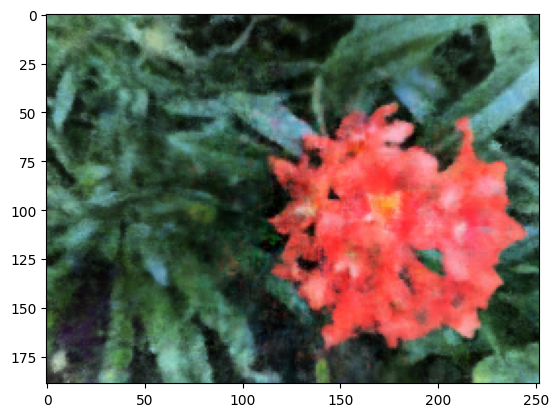

In [9]:
plt.imshow(imgs_rendered[0])

### Spiral pattern

In [10]:
from kornia.geometry.nerf.camera_utils import create_spiral_path

cameras_spiral = create_spiral_path(cameras, rad=1., num_views=30, num_circles=2)
imgs_rendered_spiral = nerf_obj.render_views(cameras_spiral)

In [11]:
import numpy as np
import imageio

imgs_rendered_spiral_numpy = [img_rendered_spiral.cpu().numpy() for img_rendered_spiral in imgs_rendered_spiral]

dir = 'kornia/geometry/nerf/kornia_nerf_data/flower_4'
scene_name = 'flower_4'
gif_path = os.path.join(dir, scene_name + '_spiral.gif')
imageio.mimwrite(gif_path, imgs_rendered_spiral_numpy, fps=30)

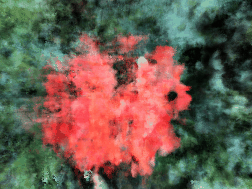

In [12]:
from IPython.display import Image
Image(open(gif_path, 'rb').read())